[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/mees.ipynb)

# Optimizing with MEES in JAX

This notebook shows how to use QDax to find diverse and performing controllers with MAP-Elites-ES introduced in [Scaling MAP-Elites to Deep Neuroevolution](https://dl.acm.org/doi/pdf/10.1145/3377930.3390217).
It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create the MEES emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualize the results of the training process

In [1]:
from IPython.display import clear_output

try:
    import qdax
except:
    print("QDax not found. Installing...")
    !pip install qdax[cuda12]
    import qdax

clear_output()

In [2]:
!pip install ipympl | tail -n 1
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

import os

from IPython.display import clear_output
import functools
import time

import jax
import jax.numpy as jnp

from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids
from qdax import environments
from qdax.tasks.brax_envs import scoring_function_brax_envs
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.utils.plotting import plot_map_elites_results
from qdax.utils.sampling import sampling

from qdax.core.emitters.mees_emitter import MEESConfig, MEESEmitter
from qdax.utils.metrics import CSVLogger, default_qd_metrics


if "COLAB_TPU_ADDR" in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

clear_output()

In [3]:
#@title QD Training Definitions Fields
#@markdown ---
env_name = 'walker2d_uni'#@param['walker2d_uni', 'ant_uni', 'hopper_uni', 'walker_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
episode_length = 100 #@param {type:"integer"}
num_iterations = 100 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
policy_hidden_layer_sizes = (64, 64) #@param {type:"raw"}
num_init_cvt_samples = 50000 #@param {type:"integer"}
num_centroids = 1024 #@param {type:"integer"}
min_descriptor = 0. #@param {type:"number"}
max_descriptor = 1.0 #@param {type:"number"}

#@title MEES Emitter Definitions Fields
sample_number = 1000 #@param {type:"integer"}
sample_sigma = 0.02 #@param {type:"number"}
num_optimizer_steps = 10 #@param {type:"integer"}
learning_rate = 0.01 #@param {type:"number"}
l2_coefficient = 0.02 #@param {type:"number"}
novelty_nearest_neighbors = 10 #@param {type:"integer"}
last_updated_size = 5 #@param {type:"integer"}
exploit_num_cell_sample = 2 #@param {type:"integer"}
explore_num_cell_sample = 5 #@param {type:"integer"}
adam_optimizer = True #@param {type:"boolean"}
sample_mirror = True #@param {type:"boolean"}
sample_rank_norm = True #@param {type:"boolean"}
use_explore = True #@param {type:"boolean"}

#@markdown ---

## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use. Once the policy is defined, all individuals are defined by their parameters, that corresponds to their genotype.

In [4]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
key = jax.random.key(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Init population of controllers
key, subkey = jax.random.split(key)
fake_batch = jnp.zeros(shape=(1, env.observation_size))
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=1, axis=0)
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

# Create the initial environment state
key, subkey = jax.random.split(key)
init_state = env.reset(subkey)

## Define the way the policy interacts with the env

In [5]:
# Define the fonction to play a step with the policy in the environment
def play_step_fn(
    env_state,
    policy_params,
    key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)

    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, key, transition

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and descriptor of each individual.

In [6]:
# Prepare the scoring function
descriptor_extraction_fn = environments.descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function_brax_envs,
    episode_length=episode_length,
    play_reset_fn=lambda key: init_state,
    play_step_fn=play_step_fn,
    descriptor_extractor=descriptor_extraction_fn,
)

# Prepare the scoring functions for the offspring generated folllowing
# the approximated gradient (each of them is evaluated 30 times)
sampling_fn = functools.partial(
    sampling,
    scoring_fn=scoring_fn,
    num_samples=30,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

## Define the emitter: MEES Emitter

The emitter is used to evolve the population at each mutation step. In this example, the emitter is the MAP-Elites-ES approximated gradient emitter, the one used in "Scaling MAP-Elites to Deep Neuroevolution".
At every generations, it uses samples-approximated gradients to improve the solutions of the archive.Half of the time it approximates the gradient of fitness and half of the time the gradient of novelty.

In [7]:
# Define the MEES-emitter config
mees_emitter_config = MEESConfig(
    sample_number=sample_number,
    sample_sigma=sample_sigma,
    sample_mirror=sample_mirror,
    sample_rank_norm=sample_rank_norm,
    num_optimizer_steps=num_optimizer_steps,
    adam_optimizer=adam_optimizer,
    learning_rate=learning_rate,
    l2_coefficient=l2_coefficient,
    novelty_nearest_neighbors=novelty_nearest_neighbors,
    last_updated_size=last_updated_size,
    exploit_num_cell_sample=exploit_num_cell_sample,
    explore_num_cell_sample=explore_num_cell_sample,
    use_explore=use_explore,
)

In [8]:
# Get the emitter
mees_emitter = MEESEmitter(
    config=mees_emitter_config,
    total_generations=num_iterations,
    scoring_fn=scoring_fn,
    num_descriptors=env.descriptor_length,
)

## Instantiate and initialise the MAP Elites algorithm

In [9]:
# Instantiate MAP Elites
map_elites = MAPElites(
    scoring_function=sampling_fn,
    emitter=mees_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
key, subkey = jax.random.split(key)
centroids = compute_cvt_centroids(
    num_descriptors=env.descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_descriptor,
    maxval=max_descriptor,
    key=subkey,
)

# compute initial repertoire
key, subkey = jax.random.split(key)
repertoire, emitter_state = map_elites.init(
    init_variables, centroids, subkey
)

/home_nfs/maxence/projects/tmp/qdax/core/map_elites.py:80: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


In [12]:
log_period = 10
num_loops = num_iterations // log_period

metrics = dict.fromkeys(["iteration", "qd_score", "coverage", "max_fitness", "time"], jnp.array([]))
csv_logger = CSVLogger(
    "mees-logs.csv",
    header=list(metrics.keys())
)

# Main loop
map_elites_scan_update = map_elites.scan_update
for i in range(num_loops):
    start_time = time.time()
    (
        repertoire,
        emitter_state,
        key,
    ), current_metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time

    # Metrics
    current_metrics["iteration"] = jnp.arange(1+log_period*i, 1+log_period*(i+1), dtype=jnp.int32)
    current_metrics["time"] = jnp.repeat(timelapse, log_period)
    metrics = jax.tree.map(lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0), metrics, current_metrics)

    # Log
    csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

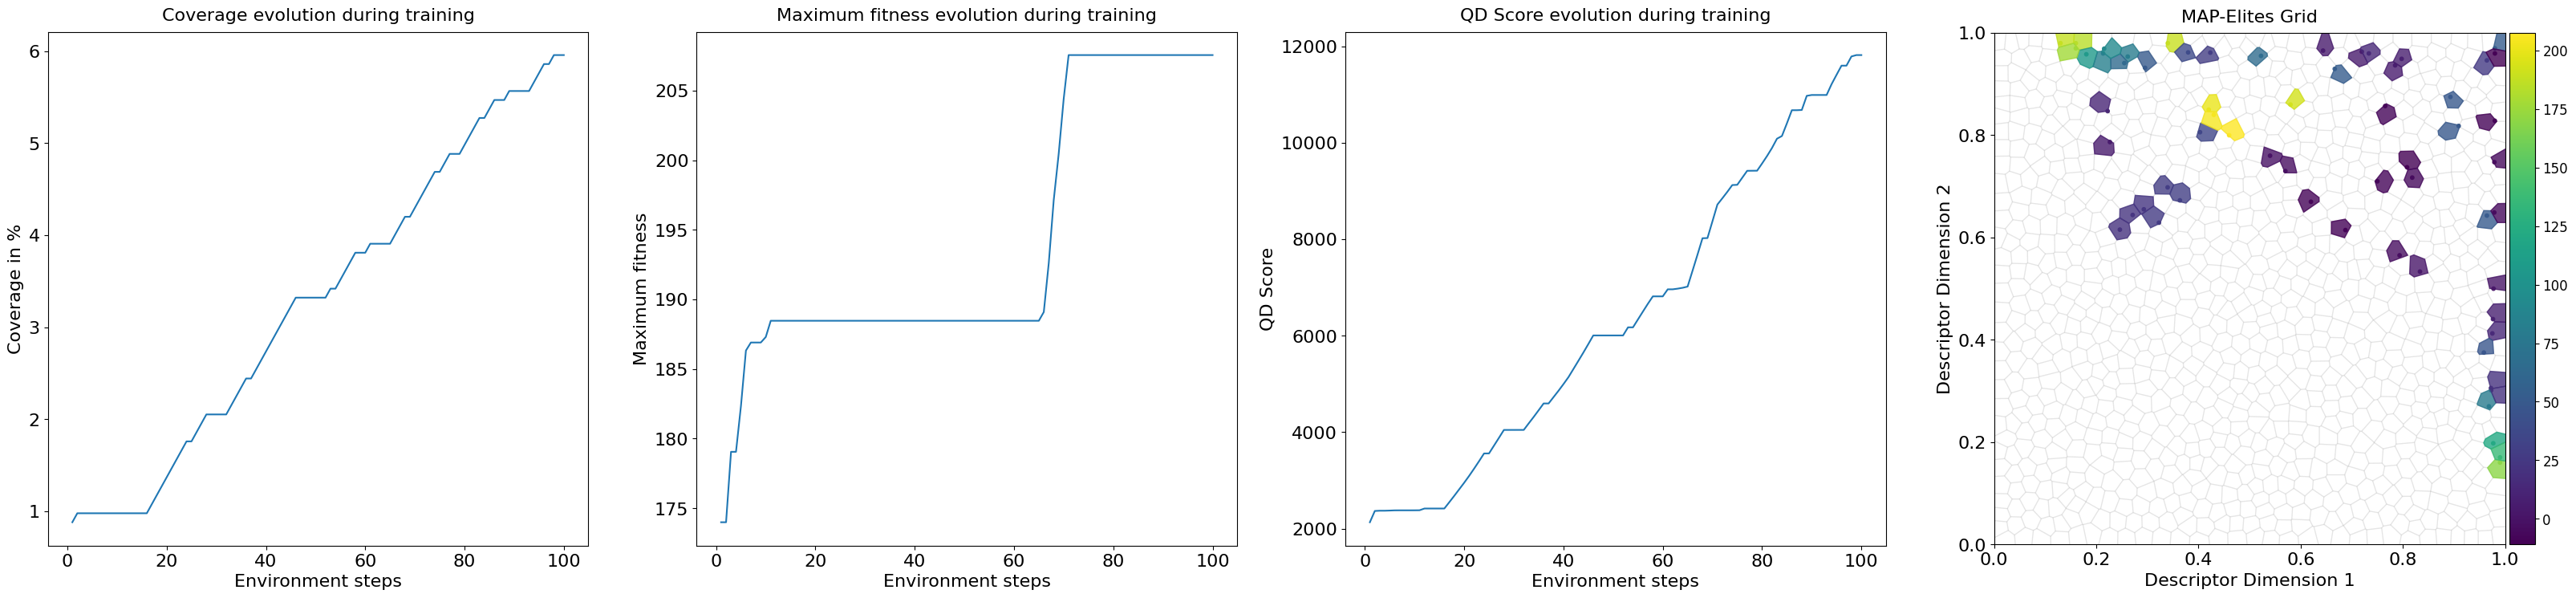

In [13]:
#@title Visualization

# Create the x-axis array
env_steps = metrics["iteration"]

%matplotlib inline
# Create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_descriptor=min_descriptor, max_descriptor=max_descriptor)